## Обработка графиков ЭКГ и преобразование в таблицу

In [ ]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
from peakdetect import peakdetect
from category_encoders.target_encoder import TargetEncoder

In [ ]:
import cupy

In [ ]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [ ]:
def gpu_get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = cp.asnumpy(cp.load(way).transpose().reshape((60000,)))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [ ]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [ ]:
def gpu_into_one_table(keys, directory): # преобразование графиков в таблицу
    row = gpu_get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [ ]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-2])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 12.3 s
Wall time: 14.9 s


In [ ]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'ecg_id'})

In [ ]:
ECG_data = ECG_data.sort_values(by=['ecg_id'], ascending=True)

In [ ]:
ECG_data

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


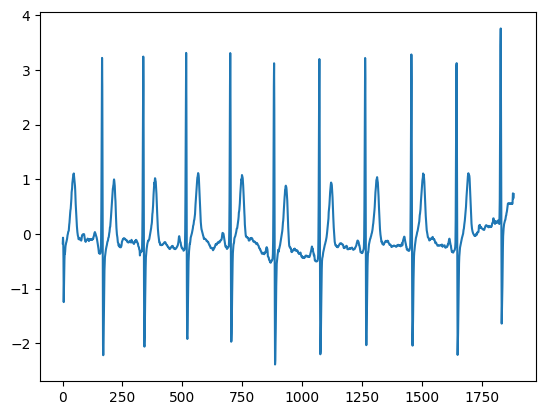

In [ ]:
plt.plot(ECG_data.loc[0, 1:]) # график экг после обработки сигнала

## N-граммы

In [ ]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [ ]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [ ]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [ ]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [ ]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [ ]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [ ]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [ ]:
ECG_data_array = np.array(ECG_data)

In [ ]:
R_Peaks = []

In [ ]:
ecg_ids = []
encoding_ecgs = []

In [ ]:
for ecgsignal in ECG_data_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids.append(ecg_id)
    encoding_ecgs.append(encoding_ecg)

In [ ]:
encoding_ecg = pd.Series(encoding_ecgs, index=ecg_ids)

In [ ]:
gts = pd.read_csv('train/train_gts.csv')  # данные из файла train_gts.csv
gts.record_name = gts.record_name.map(lambda x: float(x[:-3]))
gts = gts.sort_values(by='record_name')
gts.insert(2, 'encoding_ecg', array(encoding_ecg))
gts

,record_name,myocard,encoding_ecg
265,9.0,0,DDCADDCC
1407,34.0,0,DDDCCCFFFDDFCCCACFE
1833,43.0,0,BFABCFADDEC
441,52.0,0,DDEFBCCBCCF
1834,57.0,0,DDCADBCDD
...,...,...,...
1753,21784.0,0,DDCCFFAFAFFAFC
2008,21795.0,0,
72,21825.0,0,ECCDDDECB
2100,21831.0,0,DAFCCDDDCFCD


In [ ]:
array(gts)

array([[9.0, 0, 'DDCADDCC'],
       [34.0, 0, 'DDDCCCFFFDDFCCCACFE'],
       [43.0, 0, 'BFABCFADDEC'],
       ...,
       [21825.0, 0, 'ECCDDDECB'],
       [21831.0, 0, 'DAFCCDDDCFCD'],
       [21834.0, 1, 'CDFCCDAFF']], dtype=object)

In [ ]:
sick = gts[gts.myocard == 1].encoding_ecg  # закодированные кардиограммы больных
healthy = gts[gts.myocard == 0].encoding_ecg  # закодированные кардиограммы здоровых

In [ ]:
sp_sick= []  # список N-грамм больных
for i in sick:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_sick.append(k)

In [ ]:
sp_healthy = []  # список N-грамм здоровых
for i in healthy:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_healthy.append(k)

In [ ]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [ ]:
q_sick = counter_and_sort(sp_sick) # отсортированные н-граммы больных
q_health = counter_and_sort(sp_healthy)  # отсортированные н-граммы здоровых

In [ ]:
only_sick = list(set(q_sick.index) - set(q_health.index)) # н-граммы, встречающиеся только у больных
only_health = list(set(q_health.index) - set(q_sick.index)) # н-граммы, встречающиеся только у здоровых

In [ ]:
popular_sick = q_sick.iloc[:len(q_sick) // 2] # н-граммы, чаще всего встречающиеся у больных
popular_health = q_health.iloc[:len(q_health) // 2] # н-граммы, чаще всего встречающиеся у здоровых

In [ ]:
# н-граммы, которые чаще всего встречаются у больных и не встречаются у здоровых
popular_sick_only = list(set(popular_sick.index) - set(popular_health.index))

# н-граммы, которые чаще всего встречаются у здоровых и не встречаются у больных
popular_health_only = list(set(popular_health.index) - set(popular_sick.index))

In [ ]:
ngramms_ecgs = []  # список н-грамм в кардиограммах
for ecg in array(gts):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[2]), 6))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs.append(list(ngramms_ecg))

In [ ]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    ng_health = sum(list(map(lambda x: 1 if x in only_health else 0, ng)))
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))

    ng_popular_health = sum(list(map(lambda x: 1 if x in popular_health_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))

    return [ng_health, ng_sick, ng_popular_health, ng_popular_sick]

In [ ]:
arr = pd.DataFrame([func(ng) for ng in ngramms_ecgs])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(arr, gts.myocard, random_state=0, test_size=0.75)
# разбиение на тестовый и тренировочный датасет

In [ ]:
cat_n_gramms = CatBoostClassifier(depth=9,  learning_rate=0.03)
cat_n_gramms.fit(X_train, y_train)

0:	learn: 0.6444023	total: 4.31ms	remaining: 4.3s
1:	learn: 0.6138423	total: 6.67ms	remaining: 3.33s
2:	learn: 0.5774073	total: 10.9ms	remaining: 3.63s
3:	learn: 0.5306864	total: 13ms	remaining: 3.23s
4:	learn: 0.4964606	total: 17.4ms	remaining: 3.46s
5:	learn: 0.4700599	total: 21.5ms	remaining: 3.56s
6:	learn: 0.4540542	total: 23.9ms	remaining: 3.39s
7:	learn: 0.4295647	total: 26.3ms	remaining: 3.26s
8:	learn: 0.4147643	total: 28.8ms	remaining: 3.17s
9:	learn: 0.3949265	total: 32.8ms	remaining: 3.25s
10:	learn: 0.3697582	total: 34.6ms	remaining: 3.11s
11:	learn: 0.3527951	total: 38.8ms	remaining: 3.19s
12:	learn: 0.3357232	total: 42.8ms	remaining: 3.25s
13:	learn: 0.3178687	total: 47.1ms	remaining: 3.31s
14:	learn: 0.3044209	total: 51.1ms	remaining: 3.36s
15:	learn: 0.2972470	total: 55.4ms	remaining: 3.41s
16:	learn: 0.2931901	total: 58.8ms	remaining: 3.4s
17:	learn: 0.2835730	total: 62.9ms	remaining: 3.43s
18:	learn: 0.2761427	total: 67.1ms	remaining: 3.46s
19:	learn: 0.2699636	total

188:	learn: 0.1655538	total: 790ms	remaining: 3.39s
189:	learn: 0.1655441	total: 798ms	remaining: 3.4s
190:	learn: 0.1655081	total: 802ms	remaining: 3.4s
191:	learn: 0.1654959	total: 809ms	remaining: 3.4s
192:	learn: 0.1654006	total: 815ms	remaining: 3.41s
193:	learn: 0.1653423	total: 822ms	remaining: 3.41s
194:	learn: 0.1653380	total: 827ms	remaining: 3.41s
195:	learn: 0.1653301	total: 834ms	remaining: 3.42s
196:	learn: 0.1653076	total: 841ms	remaining: 3.43s
197:	learn: 0.1652475	total: 847ms	remaining: 3.43s
198:	learn: 0.1652389	total: 853ms	remaining: 3.43s
199:	learn: 0.1652362	total: 857ms	remaining: 3.43s
200:	learn: 0.1651855	total: 863ms	remaining: 3.43s
201:	learn: 0.1651755	total: 869ms	remaining: 3.43s
202:	learn: 0.1651116	total: 875ms	remaining: 3.44s
203:	learn: 0.1651068	total: 882ms	remaining: 3.44s
204:	learn: 0.1650917	total: 886ms	remaining: 3.43s
205:	learn: 0.1650161	total: 891ms	remaining: 3.44s
206:	learn: 0.1649998	total: 895ms	remaining: 3.43s
207:	learn: 0.1

349:	learn: 0.1611809	total: 1.77s	remaining: 3.29s
350:	learn: 0.1611669	total: 1.78s	remaining: 3.29s
351:	learn: 0.1611551	total: 1.78s	remaining: 3.29s
352:	learn: 0.1611426	total: 1.79s	remaining: 3.28s
353:	learn: 0.1611319	total: 1.8s	remaining: 3.28s
354:	learn: 0.1611191	total: 1.8s	remaining: 3.28s
355:	learn: 0.1611087	total: 1.81s	remaining: 3.27s
356:	learn: 0.1610985	total: 1.82s	remaining: 3.27s
357:	learn: 0.1610882	total: 1.82s	remaining: 3.27s
358:	learn: 0.1610763	total: 1.83s	remaining: 3.27s
359:	learn: 0.1610655	total: 1.83s	remaining: 3.26s
360:	learn: 0.1610561	total: 1.84s	remaining: 3.26s
361:	learn: 0.1610441	total: 1.85s	remaining: 3.25s
362:	learn: 0.1610344	total: 1.85s	remaining: 3.25s
363:	learn: 0.1610230	total: 1.86s	remaining: 3.25s
364:	learn: 0.1610137	total: 1.87s	remaining: 3.25s
365:	learn: 0.1610040	total: 1.87s	remaining: 3.24s
366:	learn: 0.1609924	total: 1.88s	remaining: 3.24s
367:	learn: 0.1609836	total: 1.88s	remaining: 3.23s
368:	learn: 0.

538:	learn: 0.1601767	total: 2.96s	remaining: 2.54s
539:	learn: 0.1601743	total: 2.97s	remaining: 2.53s
540:	learn: 0.1601720	total: 2.98s	remaining: 2.53s
541:	learn: 0.1601695	total: 2.98s	remaining: 2.52s
542:	learn: 0.1601668	total: 2.99s	remaining: 2.52s
543:	learn: 0.1601645	total: 3s	remaining: 2.51s
544:	learn: 0.1601622	total: 3s	remaining: 2.51s
545:	learn: 0.1601598	total: 3.01s	remaining: 2.5s
546:	learn: 0.1601573	total: 3.01s	remaining: 2.5s
547:	learn: 0.1601550	total: 3.02s	remaining: 2.49s
548:	learn: 0.1601529	total: 3.03s	remaining: 2.49s
549:	learn: 0.1601506	total: 3.03s	remaining: 2.48s
550:	learn: 0.1601484	total: 3.04s	remaining: 2.48s
551:	learn: 0.1601463	total: 3.05s	remaining: 2.47s
552:	learn: 0.1601438	total: 3.05s	remaining: 2.47s
553:	learn: 0.1601415	total: 3.06s	remaining: 2.46s
554:	learn: 0.1601394	total: 3.06s	remaining: 2.46s
555:	learn: 0.1601368	total: 3.07s	remaining: 2.45s
556:	learn: 0.1601345	total: 3.08s	remaining: 2.45s
557:	learn: 0.160132

728:	learn: 0.1598708	total: 4.16s	remaining: 1.55s
729:	learn: 0.1598699	total: 4.17s	remaining: 1.54s
730:	learn: 0.1598687	total: 4.18s	remaining: 1.54s
731:	learn: 0.1598674	total: 4.18s	remaining: 1.53s
732:	learn: 0.1598665	total: 4.19s	remaining: 1.53s
733:	learn: 0.1598653	total: 4.2s	remaining: 1.52s
734:	learn: 0.1598643	total: 4.2s	remaining: 1.51s
735:	learn: 0.1598630	total: 4.21s	remaining: 1.51s
736:	learn: 0.1598619	total: 4.22s	remaining: 1.5s
737:	learn: 0.1598607	total: 4.22s	remaining: 1.5s
738:	learn: 0.1598596	total: 4.23s	remaining: 1.49s
739:	learn: 0.1598587	total: 4.24s	remaining: 1.49s
740:	learn: 0.1598575	total: 4.24s	remaining: 1.48s
741:	learn: 0.1598565	total: 4.25s	remaining: 1.48s
742:	learn: 0.1598555	total: 4.25s	remaining: 1.47s
743:	learn: 0.1598545	total: 4.26s	remaining: 1.47s
744:	learn: 0.1598534	total: 4.27s	remaining: 1.46s
745:	learn: 0.1598525	total: 4.27s	remaining: 1.45s
746:	learn: 0.1598516	total: 4.28s	remaining: 1.45s
747:	learn: 0.15

915:	learn: 0.1597158	total: 5.36s	remaining: 492ms
916:	learn: 0.1597152	total: 5.37s	remaining: 486ms
917:	learn: 0.1597147	total: 5.38s	remaining: 480ms
918:	learn: 0.1597141	total: 5.38s	remaining: 474ms
919:	learn: 0.1597134	total: 5.39s	remaining: 469ms
920:	learn: 0.1597127	total: 5.39s	remaining: 463ms
921:	learn: 0.1597121	total: 5.4s	remaining: 457ms
922:	learn: 0.1597116	total: 5.41s	remaining: 451ms
923:	learn: 0.1597110	total: 5.41s	remaining: 445ms
924:	learn: 0.1597104	total: 5.42s	remaining: 439ms
925:	learn: 0.1597097	total: 5.43s	remaining: 434ms
926:	learn: 0.1597090	total: 5.43s	remaining: 428ms
927:	learn: 0.1597085	total: 5.44s	remaining: 422ms
928:	learn: 0.1597078	total: 5.45s	remaining: 416ms
929:	learn: 0.1597073	total: 5.45s	remaining: 410ms
930:	learn: 0.1597068	total: 5.46s	remaining: 405ms
931:	learn: 0.1597062	total: 5.46s	remaining: 399ms
932:	learn: 0.1597055	total: 5.47s	remaining: 393ms
933:	learn: 0.1597047	total: 5.48s	remaining: 387ms
934:	learn: 0

In [ ]:
f1_score(y_test, cat_n_gramms.predict(X_test), average='macro')

0.8612836391384646

In [ ]:
f1_score(y_train, cat_n_gramms.predict(X_train), average='macro')

0.8722361284939507

## Анализ HRV сигнала

In [ ]:
hrv_data = pd.DataFrame(columns=['M', 'sco', 'coefficient_cov', 'amplitude', 'y'])
#создание датафрейма со статистическими показателями сигнала

In [ ]:
hrv_data.y = gts.myocard

In [ ]:
RR = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks))

In [ ]:
M = list(map(lambda rr: rr.mean(), RR)) #подсчёт математического ожидания

In [ ]:
hrv_data.M = M

(array([321.,  37.,  12.,  14.,   7.,  12.,   1.,   5.,   5.,   1.]),
 array([2.53173721e-01, 3.63636616e+05, 7.27272979e+05, 1.09090934e+06,
        1.45454570e+06, 1.81818207e+06, 2.18181843e+06, 2.54545479e+06,
        2.90909115e+06, 3.27272752e+06, 3.63636388e+06]),
 <BarContainer object of 10 artists>)

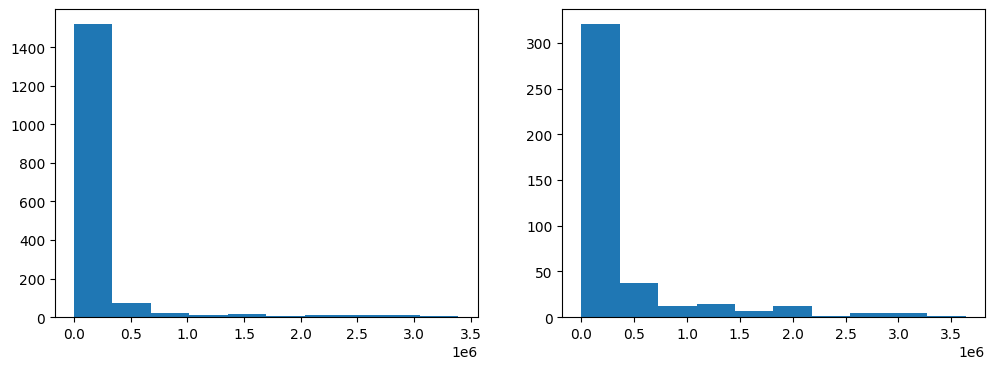

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #построение графиков для сравнения математического ожидания у больных

axes[0].hist(hrv_data.M[hrv_data.y == 0])
axes[1].hist(hrv_data.M[hrv_data.y == 1])
#как видно, особых различий в распределении у больных и здоровых нет

In [ ]:
def analysis_mat_expectation(M): #кодирование математического ожидания
    if M < 0.5:
        return 0
    elif 0.5 <= M < 0.66:
        return 1
    elif 0.66 <= M:
        return 2

In [ ]:
hrv_data.M = list(map(lambda m: analysis_mat_expectation(m), M))

In [ ]:
def moda_and_amplitude(peaks): #функция подсчёта моды и амплитуды
    eps = 0.02

    f = np.zeros(len(peaks))
    count_mode = np.zeros(len(peaks))

    for i in range(len(peaks) - 1):
        f[i] = (peaks[i + 1] - peaks[i])

    for m in range(len(f)):
        count = 0

        for t in range(len(f) - 1):
            if fabs(f[t + 1] - f[m]) / 100 < eps:
                count += 1

        count_mode[m] = count
    max = len(peaks) - 1

    for m in range(len(count_mode)):
        if count_mode[max] < count_mode[m]:
            max = m

    def amplitude_mode():
        return 100 * count_mode[max] / len(peaks)

    return amplitude_mode()

In [ ]:
def analysis_amplitude(amplitude): #кодирование амплитуды

    if 65 <= amplitude < 100:
        return 0
    else:
        return 1

In [ ]:
amplitude = list(map(lambda rpeaks: moda_and_amplitude(rpeaks), R_Peaks))

In [ ]:
hrv_data.amplitude = amplitude

(array([25., 73., 70., 76., 61., 35., 32., 13., 16., 14.]),
 array([ 7.14285714, 15.37593985, 23.60902256, 31.84210526, 40.07518797,
        48.30827068, 56.54135338, 64.77443609, 73.0075188 , 81.2406015 ,
        89.47368421]),
 <BarContainer object of 10 artists>)

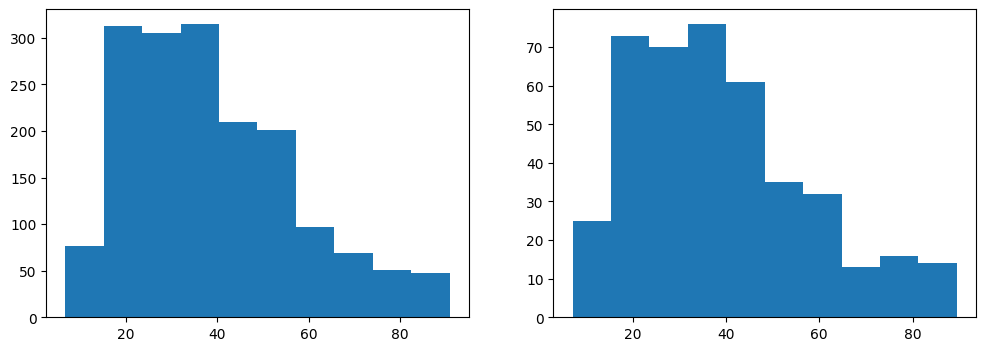

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #графики для сравнения амплитуды у больных и здоровых

axes[0].hist(hrv_data.amplitude[hrv_data.y == 0])
axes[1].hist(hrv_data.amplitude[hrv_data.y == 1])
#распределение у обеих групп совпадает и особых различий нет

In [ ]:
hrv_data.amplitude = list(map(lambda a: analysis_amplitude(a), amplitude))

In [ ]:
def SCO(array, index): #функция для подсчёта среднего квадратичного отклонения
  global ECG_data_array
  R_values = [ECG_data_array[index][j] for j in array]
  n = len(R_values)
  mean = np.array(R_values).mean()
  summ = sum([(i - mean) ** 2 for i in R_values])
  return (summ / (n - 1)) ** 0.5

In [ ]:
sco_values = [SCO(R_Peaks[i], i) for i in range(len(R_Peaks))]
hrv_data.sco = sco_values

(array([413.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.76030475e-02, 1.98928259e+02, 3.97838915e+02, 5.96749571e+02,
        7.95660226e+02, 9.94570882e+02, 1.19348154e+03, 1.39239219e+03,
        1.59130285e+03, 1.79021351e+03, 1.98912416e+03]),
 <BarContainer object of 10 artists>)

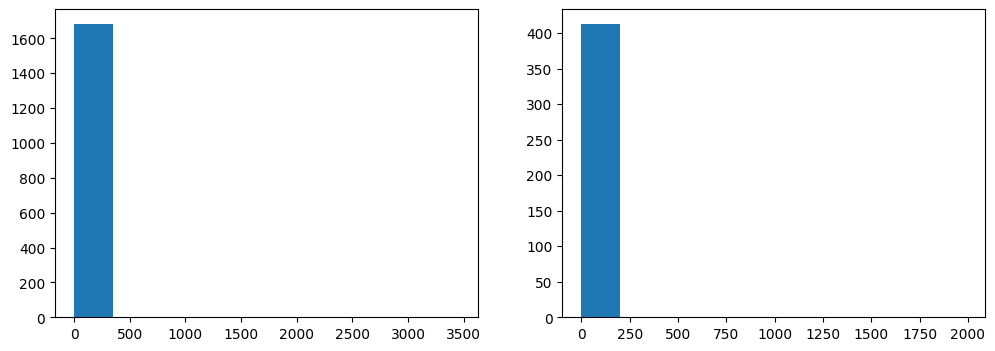

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #графики для сравнения амплитуды у больных и здоровых

axes[0].hist(hrv_data.sco[hrv_data.y == 0])
axes[1].hist(hrv_data.sco[hrv_data.y == 1])
#графики схожи и их них нельзя получить достаточно информации о различии sco у больных и здоровых

In [ ]:
def coefficient_covariance(M, SCO):
    return 100 * array(SCO) / array(M)

In [ ]:
coefficient_covariance = coefficient_covariance(M, sco_values)

In [ ]:
hrv_data.coefficient_cov = coefficient_covariance

In [ ]:
hrv_data

,M,sco,coefficient_cov,amplitude,y
265,0,0.285955,88.015834,1,0
1407,2,0.224696,31.806020,0,0
1833,0,0.182978,43.126229,1,0
441,0,0.234888,56.993168,1,0
1834,0,0.295042,84.761525,1,0
...,...,...,...,...,...
1753,1,0.190881,37.008425,0,0
2008,0,0.241930,67.041060,1,0
72,0,0.166227,46.153706,1,0
2100,0,0.087173,19.102480,1,0


## Анализ метаданных

In [ ]:
df = pd.read_csv('train/train_meta.csv')

In [ ]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
1,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
2,43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3
3,52,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2
4,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        2101 non-null   int64  
 1   patient_id                    2101 non-null   float64
 2   age                           2101 non-null   float64
 3   sex                           2101 non-null   int64  
 4   height                        689 non-null    float64
 5   weight                        905 non-null    float64
 6   nurse                         1947 non-null   float64
 7   site                          2100 non-null   float64
 8   device                        2101 non-null   object 
 9   recording_date                2101 non-null   object 
 10  report                        2101 non-null   object 
 11  scp_codes                     2101 non-null   object 
 12  heart_axis                    1231 non-null   object 
 13  inf

In [ ]:
myocard_list = list(gts['myocard'])
df.insert(loc=len(df.columns), column='myocard', value=myocard_list)

In [ ]:
combo_info = df['weight'].astype(str) + '_' + df['height'].astype(str) + '_' + df['age'].astype(str) + '_' + df['sex'].astype(str)
df.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

target_encoder_combo_info = TargetEncoder()
target_encoder_combo_info.fit(df.combo_info, df.myocard)
target_encoded_combo_info = target_encoder_combo_info.transform(df.combo_info)
df.combo_info = target_encoded_combo_info.astype('float')
#кодирование категориальных данных

In [ ]:
target_encoder_scp_codes = TargetEncoder()
target_encoder_scp_codes.fit(df.scp_codes, df.myocard)
target_encoded_scp_codes = target_encoder_scp_codes.transform(df.scp_codes)
df.scp_codes = target_encoded_scp_codes.astype('float')
#стандарт для обмена цифровыми ЭКГ

In [ ]:
target_encoder_i_s1 = TargetEncoder()
target_encoder_i_s1.fit(df.infarction_stadium1, df.myocard)
target_encoded_i_s1 = target_encoder_i_s1.transform(df.infarction_stadium1)
df.infarction_stadium1 = target_encoded_i_s1.astype('float')
#первая стадия инфаркта

target_encoder_i_s2 = TargetEncoder()
target_encoder_i_s2.fit(df.infarction_stadium2, df.myocard)
target_encoded_i_s2  = target_encoder_i_s2.transform(df.infarction_stadium2)
df.infarction_stadium2 = target_encoded_i_s2.astype('float')
#вторая стадия инфаркта

In [ ]:
oft_value1 = df['heart_axis'].value_counts().idxmax()
df['heart_axis'] = df['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением

target_encoder_heart_axis = TargetEncoder()
target_encoder_heart_axis.fit(df.heart_axis, df.myocard)
target_encoded_heart_axis = target_encoder_heart_axis.transform(df.heart_axis)
df.heart_axis = target_encoded_heart_axis.astype('float')
#электрическая ось сердца

In [ ]:
target_encoder_device = TargetEncoder()
target_encoder_device.fit(df.device, df.myocard)
target_encoded_device = target_encoder_device.transform(df.device)
df.device = target_encoded_device.astype('float')
#устройство записи

In [ ]:
target_encoder_report = TargetEncoder()
target_encoder_report.fit(df.report, df.myocard)
target_encoded_report = target_encoder_report.transform(df.report)
df.report = target_encoded_report.astype('float')
#устройство записи

In [ ]:
target_encoder_extra_beats = TargetEncoder()
target_encoder_extra_beats.fit(df.extra_beats, df.myocard)
target_encoded_extra_beats = target_encoder_extra_beats.transform(df.extra_beats)
df.extra_beats = target_encoded_extra_beats.astype('float')
#дополнительные удары сердца(обычно никак не влияют на здоров/болен)

In [ ]:
target_encoder_pacemaker = TargetEncoder()
target_encoder_pacemaker.fit(df.pacemaker, df.myocard)
target_encoded_pacemaker = target_encoder_pacemaker.transform(df.pacemaker)
df.pacemaker = target_encoded_pacemaker.astype('float')
#кардиостимулятор(регулирует функцию электрической проводящей системы сердца)

In [ ]:
oft_value2 = df['nurse'].value_counts().idxmax() #"номер" медсестры
df['nurse'] = df['nurse'].fillna(oft_value2)

oft_value3 = df['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df['validated_by'] = df['validated_by'].fillna(oft_value3)

oft_value4 = df['site'].value_counts().idxmax() #"номер" сайта записи
df['site'] = df['site'].fillna(oft_value4)

In [ ]:
df.drop(['recording_date', 'filename_lr', 'filename_hr', 'record_name',
         'age', 'sex', 'height', 'weight',
        'static_noise', 'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )
#удаление ненужных строк, в том числе содержащих различные шумы

In [ ]:
df.head()

,combo_info,ecg_id,patient_id,nurse,site,device,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,extra_beats,pacemaker,strat_fold,group,myocard
0,0.171825,9,18792.0,2.0,0.0,0.035294,0.001966,0.021776,0.138018,0.043315,0.194644,0.0,False,False,True,0.195122,0.2,10,1,0
1,0.193825,34,13619.0,2.0,0.0,0.035294,0.171825,0.167014,0.138018,0.043315,0.194644,1.0,False,False,True,0.195122,0.2,9,3,0
2,0.171825,43,11315.0,2.0,0.0,0.035294,0.001966,0.021776,0.138018,0.043315,0.194644,0.0,False,False,True,0.195122,0.2,8,3,0
3,0.171825,52,18153.0,2.0,0.0,0.035294,0.171825,0.134010,0.138018,0.043315,0.194644,0.0,False,False,True,0.195122,0.2,1,2,0
4,0.171825,57,16063.0,2.0,0.0,0.035294,0.001966,0.021776,0.138018,0.043315,0.194644,0.0,False,False,True,0.195122,0.2,10,3,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   combo_info                    2101 non-null   float64
 1   ecg_id                        2101 non-null   int64  
 2   patient_id                    2101 non-null   float64
 3   nurse                         2101 non-null   float64
 4   site                          2101 non-null   float64
 5   device                        2101 non-null   float64
 6   report                        2101 non-null   float64
 7   scp_codes                     2101 non-null   float64
 8   heart_axis                    2101 non-null   float64
 9   infarction_stadium1           2101 non-null   float64
 10  infarction_stadium2           2101 non-null   float64
 11  validated_by                  2101 non-null   float64
 12  second_opinion                2101 non-null   bool   
 13  ini

In [ ]:
df.corr()['myocard']

combo_info                      0.584285
ecg_id                          0.052896
patient_id                      0.007507
nurse                           0.030785
site                           -0.030098
device                          0.180764
report                          0.704540
scp_codes                       0.707854
heart_axis                      0.285748
infarction_stadium1             0.696046
infarction_stadium2             0.104627
validated_by                   -0.011176
second_opinion                 -0.033411
initial_autogenerated_report    0.061033
validated_by_human             -0.088836
extra_beats                     0.086123
pacemaker                       0.050054
strat_fold                     -0.024464
group                           0.004394
myocard                         1.000000
Name: myocard, dtype: float64

In [ ]:
values = df.values
X = values[:,0:18]
y = values[:,19]
y=y.astype('int')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
cat_meta = CatBoostClassifier(depth=8,  learning_rate=0.05)
cat_meta.fit(X_train, y_train)

0:	learn: 0.5940687	total: 9.11ms	remaining: 9.1s
1:	learn: 0.5187690	total: 17ms	remaining: 8.5s
2:	learn: 0.4497107	total: 25.4ms	remaining: 8.44s
3:	learn: 0.3972086	total: 33.3ms	remaining: 8.3s
4:	learn: 0.3307606	total: 41.1ms	remaining: 8.17s
5:	learn: 0.2833439	total: 48.9ms	remaining: 8.1s
6:	learn: 0.2390936	total: 56.6ms	remaining: 8.03s
7:	learn: 0.2065420	total: 64.4ms	remaining: 7.99s
8:	learn: 0.1826708	total: 72.4ms	remaining: 7.97s
9:	learn: 0.1577999	total: 80.2ms	remaining: 7.94s
10:	learn: 0.1414408	total: 87.6ms	remaining: 7.87s
11:	learn: 0.1257416	total: 95ms	remaining: 7.83s
12:	learn: 0.1142765	total: 103ms	remaining: 7.8s
13:	learn: 0.1021021	total: 111ms	remaining: 7.79s
14:	learn: 0.0932849	total: 118ms	remaining: 7.77s
15:	learn: 0.0846448	total: 126ms	remaining: 7.76s
16:	learn: 0.0773901	total: 134ms	remaining: 7.72s
17:	learn: 0.0706474	total: 141ms	remaining: 7.71s
18:	learn: 0.0650197	total: 149ms	remaining: 7.67s
19:	learn: 0.0602865	total: 156ms	rema

179:	learn: 0.0038166	total: 1.44s	remaining: 6.55s
180:	learn: 0.0037908	total: 1.45s	remaining: 6.57s
181:	learn: 0.0037576	total: 1.46s	remaining: 6.57s
182:	learn: 0.0037381	total: 1.47s	remaining: 6.57s
183:	learn: 0.0036985	total: 1.48s	remaining: 6.58s
184:	learn: 0.0036672	total: 1.5s	remaining: 6.59s
185:	learn: 0.0036218	total: 1.51s	remaining: 6.59s
186:	learn: 0.0035669	total: 1.52s	remaining: 6.59s
187:	learn: 0.0035319	total: 1.52s	remaining: 6.59s
188:	learn: 0.0034954	total: 1.53s	remaining: 6.59s
189:	learn: 0.0034742	total: 1.54s	remaining: 6.59s
190:	learn: 0.0034468	total: 1.55s	remaining: 6.59s
191:	learn: 0.0034168	total: 1.57s	remaining: 6.59s
192:	learn: 0.0033867	total: 1.58s	remaining: 6.59s
193:	learn: 0.0033521	total: 1.59s	remaining: 6.59s
194:	learn: 0.0033172	total: 1.6s	remaining: 6.6s
195:	learn: 0.0032749	total: 1.61s	remaining: 6.6s
196:	learn: 0.0032496	total: 1.62s	remaining: 6.6s
197:	learn: 0.0032209	total: 1.63s	remaining: 6.59s
198:	learn: 0.003

358:	learn: 0.0016450	total: 3.31s	remaining: 5.9s
359:	learn: 0.0016450	total: 3.32s	remaining: 5.89s
360:	learn: 0.0016450	total: 3.32s	remaining: 5.88s
361:	learn: 0.0016450	total: 3.33s	remaining: 5.88s
362:	learn: 0.0016450	total: 3.34s	remaining: 5.87s
363:	learn: 0.0016449	total: 3.35s	remaining: 5.86s
364:	learn: 0.0016449	total: 3.36s	remaining: 5.85s
365:	learn: 0.0016449	total: 3.37s	remaining: 5.84s
366:	learn: 0.0016449	total: 3.38s	remaining: 5.83s
367:	learn: 0.0016449	total: 3.39s	remaining: 5.82s
368:	learn: 0.0016449	total: 3.4s	remaining: 5.82s
369:	learn: 0.0016448	total: 3.41s	remaining: 5.81s
370:	learn: 0.0016448	total: 3.42s	remaining: 5.8s
371:	learn: 0.0016448	total: 3.43s	remaining: 5.79s
372:	learn: 0.0016448	total: 3.45s	remaining: 5.8s
373:	learn: 0.0016448	total: 3.46s	remaining: 5.79s
374:	learn: 0.0016448	total: 3.47s	remaining: 5.79s
375:	learn: 0.0016448	total: 3.48s	remaining: 5.78s
376:	learn: 0.0016448	total: 3.49s	remaining: 5.77s
377:	learn: 0.00

527:	learn: 0.0016352	total: 4.93s	remaining: 4.41s
528:	learn: 0.0016352	total: 4.94s	remaining: 4.4s
529:	learn: 0.0016352	total: 4.95s	remaining: 4.39s
530:	learn: 0.0016352	total: 4.98s	remaining: 4.39s
531:	learn: 0.0016352	total: 4.99s	remaining: 4.38s
532:	learn: 0.0016352	total: 4.99s	remaining: 4.38s
533:	learn: 0.0016352	total: 5.01s	remaining: 4.38s
534:	learn: 0.0016352	total: 5.02s	remaining: 4.37s
535:	learn: 0.0016352	total: 5.03s	remaining: 4.36s
536:	learn: 0.0016352	total: 5.04s	remaining: 4.35s
537:	learn: 0.0016352	total: 5.05s	remaining: 4.34s
538:	learn: 0.0016352	total: 5.06s	remaining: 4.33s
539:	learn: 0.0016352	total: 5.07s	remaining: 4.32s
540:	learn: 0.0016352	total: 5.08s	remaining: 4.31s
541:	learn: 0.0016352	total: 5.09s	remaining: 4.3s
542:	learn: 0.0016352	total: 5.1s	remaining: 4.29s
543:	learn: 0.0016352	total: 5.11s	remaining: 4.28s
544:	learn: 0.0016352	total: 5.12s	remaining: 4.27s
545:	learn: 0.0016352	total: 5.13s	remaining: 4.26s
546:	learn: 0.0

695:	learn: 0.0016352	total: 6.59s	remaining: 2.88s
696:	learn: 0.0016352	total: 6.6s	remaining: 2.87s
697:	learn: 0.0016352	total: 6.61s	remaining: 2.86s
698:	learn: 0.0016352	total: 6.62s	remaining: 2.85s
699:	learn: 0.0016352	total: 6.63s	remaining: 2.84s
700:	learn: 0.0016352	total: 6.64s	remaining: 2.83s
701:	learn: 0.0016352	total: 6.65s	remaining: 2.82s
702:	learn: 0.0016352	total: 6.67s	remaining: 2.82s
703:	learn: 0.0016352	total: 6.68s	remaining: 2.81s
704:	learn: 0.0016352	total: 6.69s	remaining: 2.8s
705:	learn: 0.0016352	total: 6.7s	remaining: 2.79s
706:	learn: 0.0016352	total: 6.7s	remaining: 2.78s
707:	learn: 0.0016352	total: 6.71s	remaining: 2.77s
708:	learn: 0.0016352	total: 6.72s	remaining: 2.76s
709:	learn: 0.0016352	total: 6.74s	remaining: 2.75s
710:	learn: 0.0016352	total: 6.75s	remaining: 2.74s
711:	learn: 0.0016352	total: 6.76s	remaining: 2.73s
712:	learn: 0.0016352	total: 6.77s	remaining: 2.72s
713:	learn: 0.0016352	total: 6.78s	remaining: 2.71s
714:	learn: 0.00

864:	learn: 0.0016341	total: 8.2s	remaining: 1.28s
865:	learn: 0.0016341	total: 8.21s	remaining: 1.27s
866:	learn: 0.0016341	total: 8.22s	remaining: 1.26s
867:	learn: 0.0016341	total: 8.23s	remaining: 1.25s
868:	learn: 0.0016341	total: 8.24s	remaining: 1.24s
869:	learn: 0.0016341	total: 8.25s	remaining: 1.23s
870:	learn: 0.0016341	total: 8.26s	remaining: 1.22s
871:	learn: 0.0016341	total: 8.27s	remaining: 1.21s
872:	learn: 0.0016341	total: 8.28s	remaining: 1.2s
873:	learn: 0.0016341	total: 8.28s	remaining: 1.19s
874:	learn: 0.0016341	total: 8.29s	remaining: 1.18s
875:	learn: 0.0016341	total: 8.3s	remaining: 1.18s
876:	learn: 0.0016341	total: 8.31s	remaining: 1.17s
877:	learn: 0.0016341	total: 8.32s	remaining: 1.16s
878:	learn: 0.0016341	total: 8.33s	remaining: 1.15s
879:	learn: 0.0016341	total: 8.34s	remaining: 1.14s
880:	learn: 0.0016341	total: 8.35s	remaining: 1.13s
881:	learn: 0.0016341	total: 8.36s	remaining: 1.12s
882:	learn: 0.0016341	total: 8.37s	remaining: 1.11s
883:	learn: 0.0

In [ ]:
f1_score(y_train, cat_meta.predict(X_train), average = 'macro')

1.0

In [ ]:
f1_score(y_test, cat_meta.predict(X_test), average = 'macro')

1.0

# Геометрический анализ

In [ ]:
pokaz = []
for ecg_1, ecgsignal in enumerate(ECG_data_array):
  Itg_danny = []
  T_k = [[]]
  try:
    peaks = peakdetect(ecgsignal, lookahead=7, delta=1)
    higherPeaks = np.array(peaks[0])
    lowerPeaks = np.array(peaks[1])
    del_ekg = [j-i for i, j in zip(lowerPeaks[:,0][:-1], lowerPeaks[:,0][1:])]
    itg_del = []
    for min_del_ekg in del_ekg:
      for i, j in zip(lowerPeaks[:,0][:-1], lowerPeaks[:,0][1:]):
        if j - i == min_del_ekg:
          itg_del.append(list(range(int(i), int(j)))) #поиск точек по которым возможно было бы разделить кардиограмму
    end_del = []
    for ith in sorted(unique(itg_del)): #обработка исключения
      if len(sorted(unique(itg_del))) > 100:
        continue
    for min_itg_del in sorted(unique(itg_del)):
      iop = scipy.signal.find_peaks(ecgsignal[:min_itg_del[0]], distance=30)[0]
      if len(iop) > 2:
        pass
      if min_itg_del[-1] - min_itg_del[0] > 40:
        end_del.append(min_itg_del)
      elif min_itg_del[-1] - min_itg_del[0] < 40:
        if len(end_del) > 1:
          end_del.append(end_del[-1] + min_itg_del) #уточнение и склеивание некоторых, слишком мелких участков
          end_del.pop(-2)
    vh = 0
    end_delk = []
    end_del = sorted(unique(end_del))
  except IndexError:
    continue
  except ValueError:
    continue
  def cycle_teeth(end_del, vh, end_delk, Itg_danny): #основная функция для поиска зубцов
    for k in end_del:
     k1, k2 = np.array_split(k, 2)
     if len(k1) / len(np.array_split(end_del[0], 2)[0]) > 7 and k1[0] + vh != (np.array_split(end_del[0], 2)[0])[0]: #определение допустимости использования участка
       pass
     else:
       slopes = np.diff(ecgsignal[k1]) / np.diff(k1)
       sloup = np.diff(ecgsignal[k2][::-1]) / np.diff(k2[::-1])
       scipy.signal.find_peaks(ecgsignal[k1])
       idxx = np.argmax(slopes < 0.02)
       idx = idxx
       try:
         mean_height = np.argmax(slopes[2:] < 0.02)
         mean_heighty = np.argsort(slopes < 0.02)

         mean_height = [i for i in mean_heighty if i > scipy.signal.find_peaks(ecgsignal[k1])[0][0]][-1] # нахождение дополнительной точки для определения амплитуды
       except IndexError:
         vh += len(k)
         continue
       while ecgsignal[k1][idx] < -0.5 + ecgsignal[k1][idx]:
         slopes = np.diff(ecgsignal[k1][idx + 1:]) / np.diff(k1[idx + 1:])
         idx = np.argmax(slopes < 0.05)
       tchkpT = ecgsignal[k1][idx:]
       peaks = peakdetect(ecgsignal[k1], lookahead=1)
       lowerPeaks = np.array([pek for pek in peaks[1] if pek[0] > idx])[1:]
       if lowerPeaks == [] or len(lowerPeaks) < 2:
         T_tk = np.where(ecgsignal[k1] == np.max(tchkpT))[0]
       else:
          if abs(np.max(tchkpT) - ecgsignal[k1][idx]) > abs(np.min([io[1] for io in lowerPeaks]) + ecgsignal[k1][idx]):
            T_tk = np.where(ecgsignal[k1] == np.max(tchkpT))[0]
          else:
           T_tk = np.where(ecgsignal[k1] == np.min([io[1] for io in lowerPeaks]))[0] #определение положения зубца T
       flagR_cycle = -2
       oi = False
       try:
         R_tk = scipy.signal.find_peaks(ecgsignal[k2])[0][-1]
       except IndexError:
         vh += len(k)
         continue
       try:
         while ecgsignal[k2][R_tk] not in sorted(ecgsignal[k2], reverse=True)[:5]: #определение положения зубца R
            maxTchk_k2 = (scipy.signal.find_peaks(ecgsignal[k2]))
            R_tk = maxTchk_k2[0][flagR_cycle]
            flagR_cycle -= 1
            if -(flagR_cycle) > 5:
              R_tk = maxTchk_k2[0][-1]
              break
       except IndexError:
         vh += len(k)
         continue
       if min([ecgsignal[k2][R_tk], T_k[-1]]) * 1.5 > max([ecgsignal[k2][R_tk], T_k[-1]]) and T_k[-1] != []: #сравние высот зубцов R и T
         if end_del.index(k) - 1 < len(end_del):
           vh += len(k)
           continue
         vh += len(k)
         continue
       if ecgsignal[k2][R_tk] < ecgsignal[k1][T_tk] and ecgsignal[k][T_tk + 10] < ecgsignal[k2][R_tk]:
         end_delk.append(k[::-1])
       sl = np.array_split(k2, 2)[1]
       spisok_abrabot = []
       ecgsig_1 = ecgsignal[k1]
       spisok_abrabot.append([mean_height, ecgsignal[k1][mean_height]])
       sloup = np.diff(ecgsignal[k1][int(T_tk):]) / np.diff(k1[int(T_tk):])
       idxx = [ps for ps in sloup if ps < 0.02]
       try:
         spisok_abrabot.append([T_tk, ecgsig_1[T_tk]]) #добавление зубца T в список для обработки

         T_k.append(ecgsig_1[T_tk])
       except IndexError:
        vh += len(k)
        continue

       ecgsig_2 = ecgsignal[k2]
       sloup = np.diff(ecgsignal[k2][:int(R_tk)]) / np.diff(k2[:int(R_tk)])
       idxx = [ps for ps in sloup if ps < 0.02]
       spisok_abrabot.append([R_tk, ecgsig_2[R_tk]]) #добавление зубца R в список для обработки
       try:
         pass
       except IndexError:
         vh += len(k)
         continue
       ji = []
       sp_Q = []
       try:
         if len(sl[:R_tk - len(np.array_split(k2, 2)[0])]) < max(scipy.signal.find_peaks(ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]):
           spisok_abrabot.append([0, 0])
           spisok_abrabot.append([0, 0])
           spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
           spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])]) #заполнение списка для обработки данными при невыполении условий
           spisok_abrabot.append([k, k1, k2])
           Itg_danny.append([spisok_abrabot])
           vh += len(k)
           continue
       except ValueError:
         pass
       try:
         for koord1, koord2 in zip(ecgsignal[sl][:R_tk - len(np.array_split(k2, 2)[0])][scipy.signal.find_peaks(-1 * ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]], sl[:R_tk - len(np.array_split(k2, 2)[0])][scipy.signal.find_peaks(ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]]):
           kop = 0
           ji.append(koord1)
           sp_Q.append([koord1, np.where(ecgsignal[k2] == koord1)[0]]) #наполнение списка возможными зубцами для Q
       except IndexError:
         vh += len(k)
         continue
       f = -1
       if len(sp_Q) < 4:
         if sp_Q == []:
            spisok_abrabot.append([0, 0])
            spisok_abrabot.append([0, 0])
            spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])]) #заполнение списка данными при невыполении условий
            spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
            spisok_abrabot.append([k, k1, k2])
            Itg_danny.append([spisok_abrabot])
            vh += len(k)
            continue

         if len(sp_Q) == 1:                                 #нахождение и добавление в список обработки Q в определенных условиях
          spisok_abrabot.append([sp_Q[0][1], sp_Q[0][0]])
          f = 0
         elif len(sp_Q) == 3 and sp_Q[-3] < sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-2][1], sp_Q[-2][0]])
           f = -2
         elif sp_Q[-1] > sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-2][1], sp_Q[-2][0]])
           f = -2
         elif sp_Q[-1] < sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-1][1], sp_Q[-1][0]])
           f = -1
         if len(sp_Q) > 1:
           pri = np.where(ecgsignal[k2] == max(ecgsignal[k2][scipy.signal.find_peaks(ecgsignal[k2][:int(sp_Q[f][1])])[0]][:-1]))
           spisok_abrabot.append([pri[0], ecgsignal[k2][pri[0]]])
           spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
           spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
           spisok_abrabot.append([k, k1, k2])  #заполнение списка данными при невыполении условий
           Itg_danny.append([spisok_abrabot])
         else:
          spisok_abrabot.append([0, 0])
          spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
          spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
          spisok_abrabot.append([k, k1, k2]) #заполнение списка данными при невыполении условий
          Itg_danny.append([spisok_abrabot])

       else:
         while sp_Q[f][0] > mean(ji[:-2]) or sp_Q[f - 1][0] > 0.4 + sp_Q[f][0]:
           if -(f - 1) == len(sp_Q):
             f = -2
             break
           f -= 1
         spisok_abrabot.append([sp_Q[f][1], sp_Q[f][0]])
         pri = np.where(ecgsignal[k2] == max(ecgsignal[k2][scipy.signal.find_peaks(ecgsignal[k2][:int(sp_Q[f][1])])[0]][:-1])) #итоговое заполение данными списка обработки
         spisok_abrabot.append([pri[0], ecgsignal[k2][pri[0]]])                                                                #точки P и Q и дополнительной информации
         spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
         spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
         spisok_abrabot.append([k, k1, k2])
         Itg_danny.append([spisok_abrabot])
       vh += len(k)
  if len(end_del) > 1:
    cycle_teeth(end_del, vh, end_delk, Itg_danny) #запуск функции поиска зубцов
  S_h = []
  Result = []
  for lkm in Itg_danny[:]:
    for spiy in lkm[:]:
      Otv = []
      amp_niz = spiy[0][1]
      T_h = [spiy[1][0], spiy[1][1] - amp_niz]
      R_h = [spiy[2][0], spiy[2][1] - amp_niz]
      Q_h = [spiy[3][0], spiy[3][1] - amp_niz]   #создание переменной описывающей зубцы и доп информацию
      P_h = [spiy[4][0], spiy[4][1] - amp_niz]
      S_p = [spiy[6][0], spiy[6][1] - amp_niz]
      dlin = [spiy[7][0], spiy[7][1], spiy[7][2]]
      if T_h[1] > R_h[1]:
        Otv.append(1)
      if abs(Q_h[1]) / R_h[1] > 30:
        Otv.append(2)
      if abs(Q_h[1]) / R_h[1] > 70:
        Otv.append(3)
        Otv.append(3)
      if T_h[1] < -0.1:
        Otv.append(4)
      if T_h[1] < -0.7:
        Otv.append(5)
        Otv.append(5)          #определение возможных паталогий исходя из положения высших точек зубцов и расстояния между ними
        Otv.append(5)
        Otv.append(5)
      if T_h[1] > R_h[1] / 3 * 2:
        Otv.append(5)
      elif R_h[0] - Q_h[0] > 10:
        Otv.append(6)
      elif T_h[1] > 0.7 * R_h[1]:
        Otv.append(7)
        Otv.append(7)
        Otv.append(7)
      if P_h[1] > 0.4:
        Otv.append(8)
        Otv.append(8)
      if abs(T_h[1]) / R_h[1] > 40:
        Otv.append(9)
      if S_p[1] < -2.6:
        Otv.append(10)
        Otv.append(10)
      if S_p[1] < -1.2:
        Otv.append(10)

      if int(Q_h[0]) - int(S_p[0][0]) != 0:
        if ((len(dlin[1]) - int(Q_h[0])) + int(S_p[0][0])) / len(dlin[0]) > 0.8:
          Otv.append(11)
          Otv.append(11)
      if Q_h[0] + P_h[0] != 0:
        if ((len(dlin[1]) - int(Q_h[0])) + int(P_h[0])) / len(dlin[0]) > 0.8:
          Otv.append(12)

      Result.append([Otv, len(Otv) / 8])
  dlin_res = ([len(r) for r in end_del])
  for u in dlin_res:
    if u / 3 * 2 > min(dlin_res) or max(dlin_res) / 3 * 2 > u: #добавление значений при особых условиях
      Result.append(['Y', dlin_res.index(u)])
  Rsp = []
  for razb in Itg_danny:
    for spiR in razb:
      amp_niz = spiR[0][1]
      R_h = [spiR[2][0], spiR[2][1] - amp_niz]
      Rsp.append(R_h[1])
  for Rsp1 in Rsp:
    if min(Rsp) * 1.5 < Rsp1:
      Result.append(['t', Rsp.index(Rsp1)]) #добавление значений при особых условиях
  plo = []
  jim = 1
  for res, lores in zip([i for i in Result if type(i)], [i for i in Result if type(i) == list]):
     if jim == lores[1]:
       Result[jim][1] += 0.125
     jim += 1
  jim = []
  try:
    otvG = Result[1]
  except IndexError:
    continue
  Result = [k for k in Result if k[0] not in ['Y', 't']] #получение нужной информации
  ResT = []
  ResR = []
  for Rt in Result:
    if len(Rt[0]) > 1:
      for i in range(len(Rt[0]) - 1):

        ResT.append(Rt[1])
        ResR.append(Rt[0][i]) #подсчет числа повторений определенных паталогий и их колличества на каждом участке
    else:
      ResT.append(Rt[1])
      ResR.append(Rt[0])
  for index, item in enumerate(ResR):
   if item == []:
      ResR[index] = 0
  for i in ResR:
    if type(i) == list:
      ResR[ResR.index(i)] = int(i[0])
  Rese = []
  znak = []
  reska = []
  for i, j in zip(np.unique(ResT, return_counts= True)[0], np.unique(ResR, return_counts= True)[1]):
    reska.append(j)
    Rese.append([i, j])
  if sum(reska) <= 24:
    for jiu in Rese:
      if jiu[1] > len(ResR) / 2:   #исходя из этих значений получение однозначного ответа
        if jiu[0] > 0.125:
          if jiu[0] >= 0.25:
            znak.append(1)
      if jiu[1] > len(ResR) / 3 * 2:
        if jiu[0] >= 0.5:
          znak.append(1)
      if jiu[1] > 20:
        znak.append(1)

    if len(Rese) == 1:
      pass
    else:
      if znak and ((0.25 not in [iuy[0] for iuy in Rese]) or (0.125 not in [iuy[0] for iuy in Rese]) or (0.0 not in [iuy[0] for iuy in Rese])):
        znak = []
  if znak:
    pokaz.append([1, Rese, Otv])
  elif znak == []:
    pokaz.append([0, Rese, Otv])

## Ансамбль

In [ ]:
data_ensemble = pd.DataFrame(columns=['n_gramms', 'meta'])
data_ensemble.n_gramms = cat_n_gramms.predict(arr)
data_ensemble.meta = cat_meta.predict(X)

In [ ]:
data_ensemble

,n_gramms,meta
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2096,0,0
2097,0,0
2098,0,0
2099,0,0


In [ ]:
X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = \
    train_test_split(data_ensemble, gts.myocard, random_state=0, test_size=0.999)

In [ ]:
cat_ensemble = CatBoostClassifier()
cat_ensemble.fit(X_train_ensemble, y_train_ensemble)

Learning rate set to 0.000725
0:	learn: 0.6927396	total: 2.02ms	remaining: 2.01s
1:	learn: 0.6923328	total: 3.32ms	remaining: 1.65s
2:	learn: 0.6919181	total: 4.54ms	remaining: 1.51s
3:	learn: 0.6915140	total: 6.02ms	remaining: 1.5s
4:	learn: 0.6911072	total: 7.18ms	remaining: 1.43s
5:	learn: 0.6907033	total: 8.39ms	remaining: 1.39s
6:	learn: 0.6902941	total: 9.69ms	remaining: 1.37s
7:	learn: 0.6898902	total: 11.1ms	remaining: 1.38s
8:	learn: 0.6894785	total: 12.3ms	remaining: 1.35s
9:	learn: 0.6890745	total: 13.4ms	remaining: 1.33s
10:	learn: 0.6886708	total: 14.5ms	remaining: 1.31s
11:	learn: 0.6882644	total: 15.9ms	remaining: 1.31s
12:	learn: 0.6878606	total: 17.5ms	remaining: 1.32s
13:	learn: 0.6874572	total: 18.9ms	remaining: 1.33s
14:	learn: 0.6870535	total: 20.2ms	remaining: 1.32s
15:	learn: 0.6866473	total: 21.6ms	remaining: 1.33s
16:	learn: 0.6862438	total: 22.9ms	remaining: 1.32s
17:	learn: 0.6858404	total: 24.1ms	remaining: 1.32s
18:	learn: 0.6854395	total: 25.8ms	remaining:

312:	learn: 0.5794685	total: 360ms	remaining: 789ms
313:	learn: 0.5791447	total: 361ms	remaining: 789ms
314:	learn: 0.5788265	total: 362ms	remaining: 788ms
315:	learn: 0.5785030	total: 363ms	remaining: 786ms
316:	learn: 0.5781875	total: 364ms	remaining: 785ms
317:	learn: 0.5778641	total: 365ms	remaining: 784ms
318:	learn: 0.5775463	total: 367ms	remaining: 783ms
319:	learn: 0.5772232	total: 368ms	remaining: 781ms
320:	learn: 0.5769055	total: 369ms	remaining: 780ms
321:	learn: 0.5765827	total: 370ms	remaining: 778ms
322:	learn: 0.5762678	total: 371ms	remaining: 777ms
323:	learn: 0.5759476	total: 372ms	remaining: 776ms
324:	learn: 0.5756303	total: 373ms	remaining: 774ms
325:	learn: 0.5753157	total: 374ms	remaining: 772ms
326:	learn: 0.5749906	total: 375ms	remaining: 771ms
327:	learn: 0.5746788	total: 376ms	remaining: 770ms
328:	learn: 0.5743566	total: 377ms	remaining: 768ms
329:	learn: 0.5740424	total: 378ms	remaining: 767ms
330:	learn: 0.5737256	total: 378ms	remaining: 765ms
331:	learn: 

481:	learn: 0.5285503	total: 546ms	remaining: 587ms
482:	learn: 0.5282669	total: 548ms	remaining: 586ms
483:	learn: 0.5279836	total: 549ms	remaining: 585ms
484:	learn: 0.5277058	total: 550ms	remaining: 584ms
485:	learn: 0.5274200	total: 551ms	remaining: 583ms
486:	learn: 0.5271422	total: 552ms	remaining: 581ms
487:	learn: 0.5268593	total: 553ms	remaining: 580ms
488:	learn: 0.5265818	total: 554ms	remaining: 579ms
489:	learn: 0.5262993	total: 555ms	remaining: 578ms
490:	learn: 0.5260140	total: 556ms	remaining: 576ms
491:	learn: 0.5257368	total: 557ms	remaining: 575ms
492:	learn: 0.5254544	total: 558ms	remaining: 574ms
493:	learn: 0.5251774	total: 559ms	remaining: 573ms
494:	learn: 0.5248953	total: 560ms	remaining: 571ms
495:	learn: 0.5246185	total: 561ms	remaining: 570ms
496:	learn: 0.5243364	total: 562ms	remaining: 569ms
497:	learn: 0.5240598	total: 563ms	remaining: 568ms
498:	learn: 0.5237833	total: 565ms	remaining: 567ms
499:	learn: 0.5235043	total: 566ms	remaining: 566ms
500:	learn: 

729:	learn: 0.4646639	total: 924ms	remaining: 342ms
730:	learn: 0.4644295	total: 926ms	remaining: 341ms
731:	learn: 0.4641925	total: 927ms	remaining: 339ms
732:	learn: 0.4639584	total: 928ms	remaining: 338ms
733:	learn: 0.4637244	total: 930ms	remaining: 337ms
734:	learn: 0.4634878	total: 931ms	remaining: 336ms
735:	learn: 0.4632538	total: 932ms	remaining: 334ms
736:	learn: 0.4630202	total: 933ms	remaining: 333ms
737:	learn: 0.4627864	total: 935ms	remaining: 332ms
738:	learn: 0.4625580	total: 936ms	remaining: 331ms
739:	learn: 0.4623247	total: 938ms	remaining: 329ms
740:	learn: 0.4620886	total: 940ms	remaining: 329ms
741:	learn: 0.4618579	total: 942ms	remaining: 328ms
742:	learn: 0.4616222	total: 945ms	remaining: 327ms
743:	learn: 0.4613890	total: 948ms	remaining: 326ms
744:	learn: 0.4611614	total: 950ms	remaining: 325ms
745:	learn: 0.4609286	total: 952ms	remaining: 324ms
746:	learn: 0.4606957	total: 954ms	remaining: 323ms
747:	learn: 0.4604631	total: 957ms	remaining: 322ms
748:	learn: 

903:	learn: 0.4262593	total: 1.31s	remaining: 139ms
904:	learn: 0.4260501	total: 1.31s	remaining: 137ms
905:	learn: 0.4258460	total: 1.31s	remaining: 136ms
906:	learn: 0.4256395	total: 1.31s	remaining: 134ms
907:	learn: 0.4254330	total: 1.31s	remaining: 133ms
908:	learn: 0.4252267	total: 1.31s	remaining: 132ms
909:	learn: 0.4250151	total: 1.31s	remaining: 130ms
910:	learn: 0.4248091	total: 1.31s	remaining: 129ms
911:	learn: 0.4246030	total: 1.32s	remaining: 127ms
912:	learn: 0.4243970	total: 1.32s	remaining: 126ms
913:	learn: 0.4241939	total: 1.32s	remaining: 124ms
914:	learn: 0.4239853	total: 1.32s	remaining: 123ms
915:	learn: 0.4237798	total: 1.32s	remaining: 121ms
916:	learn: 0.4235742	total: 1.32s	remaining: 120ms
917:	learn: 0.4233713	total: 1.33s	remaining: 118ms
918:	learn: 0.4231659	total: 1.33s	remaining: 117ms
919:	learn: 0.4229607	total: 1.33s	remaining: 116ms
920:	learn: 0.4227555	total: 1.33s	remaining: 114ms
921:	learn: 0.4225504	total: 1.33s	remaining: 113ms
922:	learn: 

In [ ]:
f1_score(y_train_ensemble, cat_ensemble.predict(X_train_ensemble))

1.0

In [ ]:
f1_score(y_test_ensemble, cat_ensemble.predict(X_test_ensemble))

1.0

In [ ]:
accuracy_score(y_train_ensemble, cat_ensemble.predict(X_train_ensemble))

1.0

In [ ]:
accuracy_score(y_test_ensemble, cat_ensemble.predict(X_test_ensemble))

1.0

## Предсказание для тестовой части

In [ ]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [ ]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [ ]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [ ]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [ ]:
dsvsc = pd.read_csv('train/train_gts.csv')

In [ ]:
dsvsc

,record_name,myocard
0,00669_hr,0
1,00209_hr,0
2,00777_hr,0
3,01394_hr,0
4,01618_hr,0
...,...,...
2096,20864_hr,0
2097,20967_hr,0
2098,21744_hr,0
2099,03465_hr,0


In [ ]:
ECG_data_test_array = np.array(ECG_data_test)

In [ ]:
R_Peaks_test = []

In [ ]:
ecg_ids_test = []
encoding_ecgs_test = []

In [ ]:
for ecgsignal in ECG_data_test_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_test.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_test.append(ecg_id)
    encoding_ecgs_test.append(encoding_ecg)

In [ ]:
encoding_ecg_test = pd.Series(encoding_ecgs_test, index=ecg_ids_test)

In [ ]:
encoding_ecg_test

127.0         DCCBDDFCCB
186.0             DBEBFA
193.0       CCCFDDEABCFC
198.0          ADBEDECCD
211.0                   
               ...      
21269.0          DBFEABC
21301.0    DFFACFCDFDCCC
21366.0      DBCEFAFAFCF
21547.0          CDBBCED
21836.0       DFFCFCECBB
Length: 449, dtype: object

In [ ]:
ngramms_ecgs_test = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_test):
    ngramms_ecg_test = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg), 6))))
    for k in n:
        ngramms_ecg_test.add(k)
    ngramms_ecgs_test.append(list(ngramms_ecg_test))

In [ ]:
arr_test = pd.DataFrame([func(ng) for ng in ngramms_ecgs_test])

In [ ]:
cat_n_gramms.predict(arr_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

#### Анализ метаданных

In [ ]:
df_test = pd.read_csv('test/test_meta.csv')
df_test

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,127,11926.0,22.0,1,NaN,52.0,0.0,0.0,CS-12 E,1986-01-30 13:10:31,...,", I-AVR,",NaN,NaN,NaN,NaN,9,records100/00000/00127_lr,records500/00000/00127_hr,00127_hr,1
1,186,12396.0,60.0,1,NaN,NaN,NaN,3.0,AT-6 C,1986-03-19 14:07:42,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00186_lr,records500/00000/00186_hr,00186_hr,2
2,193,17536.0,28.0,0,NaN,112.0,0.0,0.0,CS-12 E,1986-03-22 09:24:13,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00193_lr,records500/00000/00193_hr,00193_hr,1
3,198,21074.0,19.0,1,NaN,59.0,0.0,0.0,CS-12 E,1986-04-18 10:52:02,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00198_lr,records500/00000/00198_hr,00198_hr,2
4,211,18690.0,85.0,1,NaN,NaN,1.0,2.0,CS-12,1986-05-19 10:15:08,...,", leicht,",NaN,NaN,NaN,NaN,3,records100/00000/00211_lr,records500/00000/00211_hr,00211_hr,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,8951.0,44.0,0,NaN,NaN,1.0,2.0,CS-12,2000-08-15 13:20:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/21000/21269_lr,records500/21000/21269_hr,21269_hr,1
445,21301,21392.0,71.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-08-27 09:26:21,...,", I-AVF,",NaN,NaN,NaN,NaN,4,records100/21000/21301_lr,records500/21000/21301_hr,21301_hr,2
446,21366,17212.0,62.0,1,NaN,NaN,0.0,0.0,CS100 3,2000-09-18 09:06:20,...,NaN,NaN,NaN,NaN,NaN,2,records100/21000/21366_lr,records500/21000/21366_hr,21366_hr,1
447,21547,13332.0,40.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-11-11 17:01:21,...,NaN,AVL,NaN,NaN,NaN,2,records100/21000/21547_lr,records500/21000/21547_hr,21547_hr,1


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        449 non-null    int64  
 1   patient_id                    449 non-null    float64
 2   age                           449 non-null    float64
 3   sex                           449 non-null    int64  
 4   height                        142 non-null    float64
 5   weight                        197 non-null    float64
 6   nurse                         422 non-null    float64
 7   site                          449 non-null    float64
 8   device                        449 non-null    object 
 9   recording_date                449 non-null    object 
 10  report                        449 non-null    object 
 11  scp_codes                     449 non-null    object 
 12  heart_axis                    273 non-null    object 
 13  infar

In [ ]:
df_test[['weight', 'height']] = df_test[['weight', 'height']].fillna(df_test[['weight', 'height']].mean())

combo_info = df_test['weight'].astype(str) + '_' + df_test['height'].astype(str) + '_' + df_test['age'].astype(str) \
    + '_' + df_test['sex'].astype(str)
df_test.insert(0, 'combo_info', combo_info)

In [ ]:
df_test.combo_info = target_encoded_combo_info.astype('float')

df_test.infarction_stadium1 = target_encoded_i_s1.astype('float')
df_test.infarction_stadium2 = target_encoded_i_s2.astype('float')

df_test.scp_codes = target_encoded_scp_codes.astype('float')

oft_value1 = df_test['heart_axis'].value_counts().idxmax()
df_test['heart_axis'] = df_test['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением
df_test.heart_axis = target_encoded_heart_axis.astype('float')

df_test.device = target_encoded_device.astype('float')

df_test.report = target_encoded_report.astype('float')

df_test.extra_beats = target_encoded_extra_beats.astype('float')

df_test.pacemaker = target_encoded_pacemaker.astype('float')

In [ ]:
oft_value2 = df_test['nurse'].value_counts().idxmax() #"номер" медсестры
df_test['nurse'] = df_test['nurse'].fillna(oft_value2)

oft_value3 = df_test['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df_test['validated_by'] = df_test['validated_by'].fillna(oft_value3)

oft_value4 = df_test['site'].value_counts().idxmax() #"номер" сайта записи
df_test['site'] = df_test['site'].fillna(oft_value4)

In [ ]:
df_test.drop(['recording_date', 'filename_lr', 'filename_hr', 'record_name',
         'age', 'sex', 'height', 'weight',
        'static_noise', 'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   combo_info                    449 non-null    float64
 1   ecg_id                        449 non-null    int64  
 2   patient_id                    449 non-null    float64
 3   nurse                         449 non-null    float64
 4   site                          449 non-null    float64
 5   device                        449 non-null    float64
 6   report                        449 non-null    float64
 7   scp_codes                     449 non-null    float64
 8   heart_axis                    449 non-null    float64
 9   infarction_stadium1           449 non-null    float64
 10  infarction_stadium2           449 non-null    float64
 11  validated_by                  449 non-null    float64
 12  second_opinion                449 non-null    bool   
 13  initi

In [ ]:
data_ensemble_test = pd.DataFrame(columns=['n_gramms', 'meta'])

In [ ]:
data_ensemble_test.n_gramms = cat_n_gramms.predict(arr_test)

In [ ]:
data_ensemble_test.meta = cat_meta.predict(df_test)

In [ ]:
cat_ensemble.predict(data_ensemble_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,